In [1]:
# Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Reshape, Permute, Bidirectional, Add, Attention, Flatten, TimeDistributed, Conv2DTranspose, Conv2D, Layer, Concatenate, Multiply, AdditiveAttention # Added Multiply, AdditiveAttention for potential SelfAttention implementation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop # Added RMSprop as an option for WGAN
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, f1_score, roc_curve # Moved confusion_matrix here
import librosa
import soundfile as sf
# import noisereduce as nr # Consider if still needed/effective
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import logging
from tqdm.notebook import tqdm # Use tqdm.notebook for better Jupyter integration
import random
import seaborn as sns # Added for confusion matrix plotting
tf.config.optimizer.set_jit(False)
print("XLA JIT compilation disabled.")

# WGAN-GP specific
from tensorflow import GradientTape

# Create directory for saving figures
FIGURES_DIR = 'training_figures_wgan_sa' # Changed dir name
os.makedirs(FIGURES_DIR, exist_ok=True)

# Configure logging
logging.basicConfig(filename='audio_errors_wgan_sa.log', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

print(f"TensorFlow version: {tf.__version__}")

2025-04-05 02:28:09.015250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 02:28:09.029288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743800289.044727  871463 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743800289.049234  871463 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743800289.061700  871463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

XLA JIT compilation disabled.
TensorFlow version: 2.19.0


In [2]:
# Cell 2: Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU devices found. Falling back to CPU.")

# Set mixed precision policy if desired (can speed up training on compatible GPUs)
#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)
#print('Mixed precision enabled')

GPU is available and configured.


In [3]:
# Cell 3: Audio Loading and Preprocessing Function
def load_and_preprocess_audio(file_path, sr=16000, duration=4):
    try:
        # Load audio, potentially reducing noise first if beneficial
        audio, current_sr = librosa.load(file_path, sr=None, duration=duration) # Load native SR first

        # Optional: Noise Reduction (experiment if needed)
        # audio = nr.reduce_noise(y=audio, sr=current_sr)

        # Resample if necessary
        if current_sr != sr:
            audio = librosa.resample(audio, orig_sr=current_sr, target_sr=sr)

        # Pad or truncate to fixed duration *before* augmentation/normalization
        target_len = sr * duration
        if len(audio) < target_len:
            audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
        else:
            audio = audio[:target_len]

        # Data Augmentation (applied *before* normalization)
        if np.random.random() < 0.5: # 50% chance
            augmentation_type = np.random.choice(['noise', 'pitch', 'speed'])
            if augmentation_type == 'noise':
                noise_amp = 0.005 * np.random.uniform(0.1, 1.0) * np.max(np.abs(audio)) # Scale noise relative to audio
                noise = np.random.randn(len(audio)) * noise_amp
                audio = audio + noise
            elif augmentation_type == 'pitch':
                pitch_shift_steps = np.random.uniform(-2.5, 2.5)
                audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_shift_steps)
            else: # speed (time stretch)
                speed_rate = np.random.uniform(0.85, 1.15)
                audio = librosa.effects.time_stretch(audio, rate=speed_rate)
                 # Time stretching changes length, re-pad/truncate
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
                else:
                    audio = audio[:target_len]

        # Normalize audio (peak normalization) - crucial for consistency
        max_amp = np.max(np.abs(audio))
        if max_amp > 1e-6: # Avoid division by zero
             audio = audio / max_amp
        # Optional: RMS normalization instead
        # rms = np.sqrt(np.mean(audio**2))
        # if rms > 1e-6:
        #    audio = audio / rms * 0.5 # Scale to a target RMS

        return audio
    except Exception as e:
        logging.error(f"Error loading/preprocessing {file_path}: {e}")
        print(f"Error loading/preprocessing {file_path}: {e}")
        return None

In [4]:
# Cell 4: Feature Extraction Function
def extract_features(audio, sr=16000, n_mels=80, n_fft=2048, hop_length=512):
    if audio is None:
        return None
    try:
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=sr,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length
        )
        # Convert to log scale (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize features (per spectrogram) - Standard Scaling
        mean = np.mean(log_mel_spec)
        std = np.std(log_mel_spec)
        if std > 1e-6: # Avoid division by zero
            log_mel_spec = (log_mel_spec - mean) / std
        else:
            log_mel_spec = log_mel_spec - mean # Just center if std is near zero

        # Ensure the shape is consistent (should be handled by fixed duration loading)
        # Expected frames: int(np.ceil(target_len / hop_length)) -> int(ceil(16000*4/512)) = 125? Check calculation
        # target_len = 16000 * 4 = 64000
        # expected_frames = 64000 // hop_length + 1 if 64000 % hop_length != 0 else 64000 // hop_length
        # expected_frames = 64000 / 512 = 125. Check librosa padding. It often adds a frame. Let's stick to TARGET_FRAMES=126 based on previous findings.

        return log_mel_spec # Shape (n_mels, n_frames) e.g. (80, 126)

    except Exception as e:
        logging.error(f"Error extracting features: {e}")
        print(f"Error extracting features: {e}")
        return None

In [5]:
# Cell 5: Class Distribution Analysis Function
def analyze_class_distribution(data_path):
    try:
        real_dir = os.path.join(data_path, 'real')
        fake_dir = os.path.join(data_path, 'fake')
        real_count = len([f for f in os.listdir(real_dir) if f.endswith('.wav')]) if os.path.exists(real_dir) else 0
        fake_count = len([f for f in os.listdir(fake_dir) if f.endswith('.wav')]) if os.path.exists(fake_dir) else 0
        total = real_count + fake_count
        if total == 0:
            print(f"\nNo .wav files found in {data_path}")
            return {'real': 0, 'fake': 0}
        print(f"\nClass Distribution for {data_path}:")
        print(f"Real: {real_count} ({real_count/total*100:.2f}%)")
        print(f"Fake: {fake_count} ({fake_count/total*100:.2f}%)")
        return {'real': real_count, 'fake': fake_count}
    except FileNotFoundError:
        print(f"\nError: Data path not found - {data_path}")
        return {'real': 0, 'fake': 0}
    except Exception as e:
        logging.error(f"Error analyzing distribution for {data_path}: {e}")
        print(f"Error analyzing distribution for {data_path}: {e}")
        return {'real': 0, 'fake': 0}

In [6]:
# Cell 6: Data Generators

# Define the fixed number of frames for GAN/Classifier consistency
TARGET_FRAMES = 126 # Recalculate based on sr=16000, duration=4, hop_length=512 if needed

# Data generator for STANDALONE CLASSIFIER training (Yields X, y, sample_weights)
# --- (data_generator_classifier function remains the same as corrected before) ---
def data_generator_classifier(data_path, batch_size=32, shuffle=True, target_frames=TARGET_FRAMES, sr=16000, duration=4, n_mels=80, n_fft=2048, hop_length=512):
    real_files = []
    fake_files = []
    try:
        real_dir = os.path.join(data_path, 'real')
        fake_dir = os.path.join(data_path, 'fake')
        if os.path.exists(real_dir):
             real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')]
        if os.path.exists(fake_dir):
             fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]
    except FileNotFoundError as e:
        print(f"Error finding directories in {data_path}: {e}")
        return

    all_files = real_files + fake_files
    labels = [1] * len(real_files) + [0] * len(fake_files) # Real=1, Fake=0

    if not all_files:
        print(f"No WAV files found in {data_path}. Classifier generator stopping.")
        return

    total_samples = len(all_files)
    class_weights = {
        1: total_samples / (2 * len(real_files)) if len(real_files) > 0 else 1.0,
        0: total_samples / (2 * len(fake_files)) if len(fake_files) > 0 else 1.0,
    }
    print(f"Using class weights: {class_weights} for path {data_path}")


    indices = np.arange(total_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)

        for i in range(0, total_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_files = [all_files[k] for k in batch_indices]
            batch_labels = [labels[k] for k in batch_indices]

            batch_x = []
            batch_y = []
            batch_sample_weights = []

            for file_path, label in zip(batch_files, batch_labels):
                audio = load_and_preprocess_audio(file_path, sr=sr, duration=duration)
                if audio is None: continue

                features = extract_features(audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                if features is None: continue

                current_frames = features.shape[1]
                if current_frames != target_frames:
                     if current_frames < target_frames:
                        pad_width = target_frames - current_frames
                        padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                     else:
                        padded_features = features[:, :target_frames]
                else:
                    padded_features = features

                batch_x.append(padded_features)
                batch_y.append(label)
                batch_sample_weights.append(class_weights[label])

            # --- Check for classifier generator ---
            if not batch_x:
                print(f"Warning: Skipping empty batch yield in data_generator_classifier for path {data_path}")
                continue

            batch_x_4d = np.expand_dims(np.array(batch_x), axis=-1).astype(np.float32)
            batch_y_arr = np.array(batch_y).astype(np.float32)
            batch_weights_arr = np.array(batch_sample_weights).astype(np.float32)
            yield batch_x_4d, batch_y_arr, batch_weights_arr


# Data generator for WGAN training (Yields real fake samples X only)
# --- (MODIFIED data_generator_gan function) ---
def data_generator_gan(data_path, batch_size=32, shuffle=True, target_frames=TARGET_FRAMES, sr=16000, duration=4, n_mels=80, n_fft=2048, hop_length=512):
    fake_files = []
    try:
        fake_dir = os.path.join(data_path, 'fake')
        if os.path.exists(fake_dir):
             fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]
    except FileNotFoundError as e:
        print(f"Error finding fake directory in {data_path}: {e}")
        return

    if not fake_files:
        print(f"No fake WAV files found in {data_path}. GAN generator stopping.")
        return

    total_samples = len(fake_files)
    indices = np.arange(total_samples)

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for i in range(0, total_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_files = [fake_files[k] for k in batch_indices]

            batch_x = []

            for file_path in batch_files:
                audio = load_and_preprocess_audio(file_path, sr=sr, duration=duration)
                if audio is None: continue

                features = extract_features(audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                if features is None: continue

                current_frames = features.shape[1]
                if current_frames != target_frames:
                    if current_frames < target_frames:
                        pad_width = target_frames - current_frames
                        padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                    else:
                        padded_features = features[:, :target_frames]
                else:
                     padded_features = features

                batch_x.append(padded_features)

            # ---> ADD THIS CHECK for GAN generator <---
            if not batch_x:
                print(f"Warning: Skipping empty batch yield in data_generator_gan for path {data_path}")
                continue # Skip yield if batch ended up empty

            # If batch is not empty, yield the data
            batch_x_4d = np.expand_dims(np.array(batch_x), axis=-1).astype(np.float32)
            yield batch_x_4d # Yield only the features (4D array)

In [7]:
# Cell 7: Self-Attention Layer (SAGAN style)

class SelfAttention(Layer):
    """
    Self-attention layer based on SAGAN.
    Input shape: (batch, height, width, channels)
    Output shape: (batch, height, width, channels_out) where channels_out is typically channels
    """
    def __init__(self, channels_out=None, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels_out = channels_out

    def build(self, input_shape):
        self.input_channels = input_shape[-1]
        if self.channels_out is None:
            self.channels_out = self.input_channels

        # Convolution layers for query, key, value
        # Use 1x1 convolutions to reduce/transform channels
        self.f = Conv2D(self.input_channels // 8, kernel_size=1, strides=1, padding='same', name='conv_f') # Query
        self.g = Conv2D(self.input_channels // 8, kernel_size=1, strides=1, padding='same', name='conv_g') # Key
        self.h = Conv2D(self.channels_out, kernel_size=1, strides=1, padding='same', name='conv_h')        # Value

        # Final 1x1 convolution
        self.out_conv = Conv2D(self.channels_out, kernel_size=1, strides=1, padding='same', name='conv_out')

        # Learnable scale parameter
        self.gamma = self.add_weight(name='gamma', shape=(1,), initializer='zeros', trainable=True)

        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        batch_size, height, width, num_channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        location_num = height * width
        downsampled_num = location_num

        # Query (f), Key (g), Value (h) projections
        f_proj = self.f(x) # Shape: (batch, h, w, c/8)
        g_proj = self.g(x) # Shape: (batch, h, w, c/8)
        h_proj = self.h(x) # Shape: (batch, h, w, c_out)

        # Reshape for matrix multiplication
        f_flat = tf.reshape(f_proj, shape=(batch_size, location_num, self.input_channels // 8)) # (batch, h*w, c/8)
        g_flat = tf.reshape(g_proj, shape=(batch_size, location_num, self.input_channels // 8)) # (batch, h*w, c/8)
        h_flat = tf.reshape(h_proj, shape=(batch_size, location_num, self.channels_out))       # (batch, h*w, c_out)

        # Attention map calculation
        # Transpose g for matmul: (batch, c/8, h*w)
        g_flat_t = tf.transpose(g_flat, perm=[0, 2, 1])
        # Attention score: (batch, h*w, c/8) x (batch, c/8, h*w) -> (batch, h*w, h*w)
        attention_score = tf.matmul(f_flat, g_flat_t)
        attention_prob = tf.nn.softmax(attention_score, axis=-1) # Apply softmax across locations

        # Apply attention map to value projection
        # (batch, h*w, h*w) x (batch, h*w, c_out) -> (batch, h*w, c_out)
        attention_output = tf.matmul(attention_prob, h_flat)

        # Reshape back to image format
        attention_output_reshaped = tf.reshape(attention_output, shape=(batch_size, height, width, self.channels_out))

        # Apply final 1x1 convolution and scale by gamma
        o = self.out_conv(attention_output_reshaped)
        y = self.gamma * o + x # Additive skip connection

        return y

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.channels_out,)

In [8]:
# Cell 8: Generator Model (with Self-Attention)

def create_generator(latent_dim, output_shape): # output_shape (n_mels, n_frames) e.g., (80, 126)
    """Creates the generator model with Self-Attention."""
    n_mels, n_frames = output_shape
    init_h, init_w = n_mels // 8, n_frames // 8 # Calculate initial dimensions based on 3 upsamples (2*2*2=8)
    init_c = 128 # Initial channels

    if init_h * 8 != n_mels or init_w * 8 != n_frames:
         print(f"Warning: Output shape {output_shape} might not be perfectly reached with 3 strides of 2. Adjusting initial size or layers.")
         # Adjust init_w slightly if needed, e.g. target 128 -> 16, target 126 -> 16 (trim later)
         init_w = (n_frames + 7) // 8 # Ceiling division equivalent for width

    nodes = init_h * init_w * init_c

    model = Sequential(name='generator')
    model.add(Input(shape=(latent_dim,)))

    # Dense layer and reshape
    model.add(Dense(nodes))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2)) # Use negative_slope
    model.add(Reshape((init_h, init_w, init_c))) # e.g., (10, 16, 128)

    # Upsample 1: (10, 16, 128) -> (20, 32, 64)
    model.add(Conv2DTranspose(init_c // 2, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)) # Typically use_bias=False with Norm
    model.add(LayerNormalization()) # Using LayerNorm instead of BatchNorm
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))

    # Upsample 2: (20, 32, 64) -> (40, 64, 32)
    model.add(Conv2DTranspose(init_c // 4, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))

    # Add Self-Attention Layer Here (applied to 40x64 feature map)
    # Note: Attention can be computationally expensive. Apply strategically.
    model.add(SelfAttention(channels_out=init_c // 4)) # Keep channels the same
    # model.add(LayerNormalization()) # Optional normalization after attention
    # model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2)) # Optional activation after attention

    # Upsample 3: (40, 64, 32) -> (80, 128, 1)
    model.add(Conv2DTranspose(1, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='tanh'))

    # Final adjustment layer if needed (e.g., width 128 -> 126)
    current_width = init_w * 8
    if current_width != n_frames:
        print(f"Generator adding final Conv2D to adjust width from {current_width} to {n_frames}")
        # Calculate kernel size needed for 'valid' padding: K = W_in - W_out + 1
        kernel_w = current_width - n_frames + 1
        if kernel_w > 0:
             model.add(Conv2D(1, kernel_size=(1, kernel_w), padding='valid', activation='tanh'))
        else:
            # This case shouldn't happen with the init_w calculation but handle just in case
             print(f"Warning: Could not adjust width with Conv2D. Current {current_width}, Target {n_frames}")
             # May need padding='same' and cropping layer if kernel_w is not positive

    # Ensure final output shape is correct
    # model.add(Reshape((n_mels, n_frames, 1))) # Add reshape just to be certain, though last Conv should handle it

    return model

In [9]:
# Cell 9: Critic (Discriminator) Model (with Self-Attention) - NO DROPOUT

def create_critic(input_shape): # input_shape (n_mels, n_frames) e.g., (80, 126)
    """Creates the Critic model for WGAN-GP with Self-Attention. NO DROPOUT."""
    n_mels, n_frames = input_shape
    model_input_shape = (n_mels, n_frames, 1) # Expects (80, 126, 1)

    model = Sequential(name='critic')
    model.add(Input(shape=model_input_shape))

    # Layer 1
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    # model.add(Dropout(0.25)) # REMOVED

    # Layer 2
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    # model.add(Dropout(0.25)) # REMOVED

    # Add Self-Attention Layer Here
    model.add(SelfAttention(channels_out=128))

    # Layer 3
    model.add(Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    # model.add(Dropout(0.25)) # REMOVED (If you had one here)

    # Flatten and Output Score
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [10]:
# Cell 10: Define the GAN Model (Not used for WGAN-GP training loop)
# def create_gan(generator, discriminator, latent_dim):
#     """Creates the combined GAN model."""
#     # Make discriminator non-trainable
#     discriminator.trainable = False
#
#     # Stack generator and discriminator
#     gan_input = Input(shape=(latent_dim,))
#     gan_output = discriminator(generator(gan_input))
#     gan = Model(gan_input, gan_output)
#
#     return gan

In [11]:
# Cell 11: Data Path and Parameters

# Data Paths
train_data_path = 'datasetNEW/train'
dev_data_path = 'datasetNEW/dev'
eval_data_path = 'datasetNEW/eval'

# Define the fixed number of frames
TARGET_FRAMES = 126
N_MELS = 80
mel_spectrogram_shape = (N_MELS, TARGET_FRAMES)

# WGAN-GP specific parameters
latent_dim = 100
n_critic = 5         # Train critic 5 times per generator update
gp_weight = 1.0     # Gradient penalty weight
gan_epochs = 75      # WGAN often needs more epochs, adjust as needed
gan_batch_size = 8  # Adjust based on GPU memory (WGAN-GP can be memory intensive)

# Optimizers (Typical WGAN settings: lower LR, betas=(0.5, 0.9))
critic_optimizer = Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9) # TRY LOWER LR
generator_optimizer = Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9)
# critic_optimizer = RMSprop(learning_rate=0.00005) # Alternative optimizer
# generator_optimizer = RMSprop(learning_rate=0.00005)

# Create instances
generator = create_generator(latent_dim, mel_spectrogram_shape)
critic = create_critic(mel_spectrogram_shape)

# Diagnostic Code: Verify Output Shape
test_noise = tf.random.normal((1, latent_dim))
generated_image = generator(test_noise, training=False) # Use tf.random and call model directly
critic_output = critic(generated_image, training=False)
print("Shape of generated image (Generator Output):", generated_image.shape)
print("Shape of critic output:", critic_output.shape)

critic_input_shape_expected = (mel_spectrogram_shape[0], mel_spectrogram_shape[1], 1)
print("Expected shape for Critic Input:", critic_input_shape_expected)
assert generated_image.shape[1:] == critic_input_shape_expected, "Generator output shape mismatch!"
assert len(critic_output.shape) == 2 and critic_output.shape[1] == 1, "Critic output shape mismatch!"


# Report the models
print("\n--- Generator Summary ---")
generator.summary()
print("\n--- Critic Summary ---")
critic.summary()

# Parameters for standalone classifier training (can be different)
classifier_batch_size = 8 # Keep smaller for classifier fine-tuning?
classifier_epochs = 60

I0000 00:00:1743800291.578110  871463 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Generator adding final Conv2D to adjust width from 128 to 126


I0000 00:00:1743800292.267179  871463 cuda_dnn.cc:529] Loaded cuDNN version 90300


Shape of generated image (Generator Output): (1, 80, 126, 1)
Shape of critic output: (1, 1)
Expected shape for Critic Input: (80, 126, 1)

--- Generator Summary ---


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20480)          │     2,068,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 20, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 32, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 40, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 40, 64, 32)     │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 40, 64, 32)     │         2,377 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 80, 128, 1)     │           513 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 126, 1)     │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,235,406 (8.53 MB)

 Trainable params: 2,235,406 (8.53 MB)

 Non-trainable params: 0 (0.00 B)


--- Critic Summary ---


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 40, 63, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 32, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 20, 32, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 20, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 20, 32, 128)    │        37,153 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 16, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 10, 16, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 10, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        40,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,330 (2.81 MB)

 Trainable params: 735,330 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Cell 12: WGAN-GP Training Loop (Saving Critic Weights Only)

# --- Imports ---
import os
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm # Use tqdm.notebook for better Jupyter integration
import matplotlib.pyplot as plt
import logging

# Assuming necessary variables (train_data_path, gan_batch_size, latent_dim, n_critic,
# gp_weight, gan_epochs, critic_optimizer, generator_optimizer, generator, critic,
# FIGURES_DIR) and functions (data_generator_gan) are defined and accessible
# from previous cells.

# --- Loss Functions ---
def critic_loss(real_output, fake_output):
    """Wasserstein loss for the critic."""
    # Ensure outputs are float32 for stable loss calculation
    real_output = tf.cast(real_output, tf.float32)
    fake_output = tf.cast(fake_output, tf.float32)
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    """Wasserstein loss for the generator."""
    # Ensure output is float32
    fake_output = tf.cast(fake_output, tf.float32)
    return -tf.reduce_mean(fake_output)

# --- Gradient Penalty Function (Corrected) ---
def gradient_penalty(batch_size, real_images, fake_images):
    """ Calculates the gradient penalty loss for WGAN GP, handling mixed precision. """
    # Ensure both images have the same dtype before interpolation
    if real_images.dtype != fake_images.dtype:
        real_images = tf.cast(real_images, fake_images.dtype)

    # Generate interpolation alpha with the correct dtype
    alpha_shape = [tf.shape(real_images)[0]] + [1] * (len(real_images.shape) - 1)
    alpha = tf.random.uniform(shape=alpha_shape, minval=0., maxval=1., dtype=real_images.dtype)

    # Interpolate images
    interpolated = real_images + alpha * (fake_images - real_images)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated, training=True)
        pred = tf.cast(pred, tf.float32) # Cast prediction to float32 for stable GP calculation

    grads = gp_tape.gradient(pred, [interpolated])
    if grads is None or grads[0] is None:
        logging.warning("Gradients are None in gradient_penalty. Returning 0 penalty.")
        # print("Warning: Gradients are None in gradient_penalty. Returning 0 penalty.") # Optional print
        return tf.constant(0.0, dtype=tf.float32)
    grads = grads[0]
    grads = tf.cast(grads, tf.float32) # Cast gradients to float32 before norm

    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.rank(grads))))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp * gp_weight # gp_weight should be float


# --- Data Generator and Steps Calculation ---
train_gen_gan = data_generator_gan(train_data_path, batch_size=gan_batch_size)

fake_files_count = 0
try:
    fake_dir = os.path.join(train_data_path, 'fake')
    if os.path.exists(fake_dir):
        fake_files_count = len([f for f in os.listdir(fake_dir) if f.endswith('.wav')])
except FileNotFoundError:
    fake_files_count = 0

if gan_batch_size <= 0:
    raise ValueError("GAN Batch size must be positive.")
if fake_files_count == 0:
    print("Warning: No fake training files found for GAN. Setting GAN steps to 0.")
    gan_steps_per_epoch = 0
else:
    gan_steps_per_epoch = int(np.ceil(fake_files_count / float(gan_batch_size)))
    print(f"Calculated {gan_steps_per_epoch} GAN steps per epoch.")


# --- Training Step Function (Decorated with tf.function) ---
@tf.function
def train_step(real_images):
    current_batch_size = tf.shape(real_images)[0]
    # Use float32 for noise if mixed precision is enabled, otherwise default might be okay
    noise = tf.random.normal([current_batch_size, latent_dim], dtype=tf.float32)

    # Train Critic (n_critic times)
    total_crit_loss = tf.constant(0.0, dtype=tf.float32)
    for _ in tf.range(n_critic):
        with tf.GradientTape() as crit_tape:
            fake_images = generator(noise, training=True)
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)
            crit_loss = critic_loss(real_output, fake_output)
            gp = gradient_penalty(current_batch_size, real_images, fake_images)
            total_crit_loss = crit_loss + gp

        crit_gradients = crit_tape.gradient(total_crit_loss, critic.trainable_variables)
        valid_grads_and_vars = [(g, v) for g, v in zip(crit_gradients, critic.trainable_variables) if g is not None]
        if len(valid_grads_and_vars) < len(critic.trainable_variables):
             tf.print("Warning: Some critic gradients are None.")
        if len(valid_grads_and_vars) > 0:
            critic_optimizer.apply_gradients(valid_grads_and_vars)

    # Train Generator
    with tf.GradientTape() as gen_tape:
        fake_images_gen = generator(noise, training=True)
        fake_output_gen = critic(fake_images_gen, training=True)
        gen_loss = generator_loss(fake_output_gen)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    valid_grads_and_vars_gen = [(g, v) for g, v in zip(gen_gradients, generator.trainable_variables) if g is not None]
    if len(valid_grads_and_vars_gen) < len(generator.trainable_variables):
         tf.print("Warning: Some generator gradients are None.")
    if len(valid_grads_and_vars_gen) > 0:
        generator_optimizer.apply_gradients(valid_grads_and_vars_gen)

    return total_crit_loss, gen_loss


# --- WGAN-GP Training Loop ---
print("\nBegin WGAN-GP training!")

if train_gen_gan is None or gan_steps_per_epoch == 0:
    print("Skipping WGAN-GP training: Generator not initialized or no steps per epoch.")
else:
    c_loss_history = []
    g_loss_history = []

    for epoch in range(gan_epochs): # Use gan_epochs defined in Cell 11
        print(f"\nEpoch {epoch+1}/{gan_epochs}")
        epoch_pbar = tqdm(range(gan_steps_per_epoch), desc=f"Epoch {epoch+1}")

        epoch_c_loss = 0.0
        epoch_g_loss = 0.0
        batches_processed = 0

        for batch_idx in epoch_pbar:
            try:
                real_spoof_samples_np = next(train_gen_gan)
                # Ensure input to train_step is float32
                real_spoof_samples = tf.convert_to_tensor(real_spoof_samples_np, dtype=tf.float32)

                if tf.shape(real_spoof_samples)[0] == 0:
                    # print(f"Warning: Skipped empty batch at step {batch_idx}") # Optional print
                    continue

                c_loss, g_loss = train_step(real_spoof_samples)

                # Check for NaN or Inf losses (important for stability)
                if np.isnan(c_loss.numpy()) or np.isinf(c_loss.numpy()) or \
                   np.isnan(g_loss.numpy()) or np.isinf(g_loss.numpy()):
                    print(f"\nError: NaN or Inf loss detected at epoch {epoch+1}, batch {batch_idx}. Stopping training.")
                    logging.error(f"NaN/Inf loss detected: C Loss={c_loss.numpy()}, G Loss={g_loss.numpy()}. Epoch {epoch+1}, Batch {batch_idx}")
                    # Optional: Save current state before breaking if needed
                    # generator.save_weights('generator_nan_inf.weights.h5')
                    # critic.save_weights('critic_nan_inf.weights.h5')
                    raise ValueError("NaN or Inf loss detected, stopping training.") # Stop execution

                epoch_c_loss += c_loss.numpy()
                epoch_g_loss += g_loss.numpy()
                batches_processed += 1

                epoch_pbar.set_postfix({"C Loss": f"{c_loss.numpy():.4f}", "G Loss": f"{g_loss.numpy():.4f}"})

            except StopIteration:
                print(f"\nGAN Generator exhausted prematurely at batch {batch_idx}. Moving to next epoch.")
                train_gen_gan = data_generator_gan(train_data_path, batch_size=gan_batch_size)
                break

            except Exception as e:
                # Catch NaN/Inf error from the check above or other errors
                logging.error(f"Error during WGAN training epoch {epoch+1}, batch {batch_idx}: {e}", exc_info=True)
                print(f"\nError during WGAN training epoch {epoch+1}, batch {batch_idx}: {e}")
                # Decide whether to continue or break based on the error type
                if isinstance(e, ValueError) and "NaN or Inf loss" in str(e):
                     break # Stop the outer loop for NaN/Inf
                continue # Skip other problematic batches


        # Check if loop was broken due to NaN/Inf
        if np.isnan(epoch_c_loss) or np.isinf(epoch_c_loss) or np.isnan(epoch_g_loss) or np.isinf(epoch_g_loss):
             print("Training stopped due to NaN/Inf loss.")
             break # Exit the epoch loop

        # --- End-of-epoch actions ---
        if batches_processed > 0:
             avg_c_loss = epoch_c_loss / batches_processed
             avg_g_loss = epoch_g_loss / batches_processed
             c_loss_history.append(avg_c_loss)
             g_loss_history.append(avg_g_loss)
             print(f"Epoch {epoch+1} finished. Avg C Loss: {avg_c_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        else:
             print(f"Epoch {epoch+1} finished. No batches processed.")
             c_loss_history.append(np.nan)
             g_loss_history.append(np.nan)


        # --- Save Models/Weights Periodically ---
        # Save every 5 epochs and at the very last epoch
        if (epoch + 1) % 5 == 0 or (epoch + 1) == gan_epochs:
             try:
                 # Save generator as full model (assuming it doesn't have loading issues)
                 generator.save(f'generator_wgan_sa_epoch_{epoch+1}.keras')

                 # Save critic weights ONLY
                 critic_weights_filename = f'critic_wgan_sa_epoch_{epoch+1}.weights.h5' # Define filename
                 critic.save_weights(critic_weights_filename) # Use save_weights

                 print(f"Saved generator model and critic weights ({critic_weights_filename}) for epoch {epoch+1}")
             except Exception as e:
                 logging.error(f"Error saving models/weights at epoch {epoch+1}: {e}", exc_info=True)
                 print(f"Error saving models/weights at epoch {epoch+1}: {e}")


    print("\nWGAN-GP training finished (or stopped early).")

    # Final loss plot
    if c_loss_history and g_loss_history: # Plot only if history exists
         plt.figure(figsize=(10, 5))
         # Filter out NaN values for plotting if training stopped early
         epochs_ran = range(1, len([loss for loss in c_loss_history if not np.isnan(loss)]) + 1)
         plt.plot(epochs_ran, [loss for loss in c_loss_history if not np.isnan(loss)], label='Avg Critic Loss per Epoch')
         plt.plot(epochs_ran, [loss for loss in g_loss_history if not np.isnan(loss)], label='Avg Generator Loss per Epoch')
         plt.title('WGAN-GP Training Losses')
         plt.xlabel('Epoch')
         plt.ylabel('Average Loss')
         plt.legend()
         plt.grid(True)
         plot_filename = os.path.join(FIGURES_DIR, 'gan_loss_final.png')
         try:
              plt.savefig(plot_filename)
              print(f"Saved final loss plot to {plot_filename}")
         except Exception as e:
              logging.error(f"Failed to save final loss plot: {e}", exc_info=True)
              print(f"Failed to save final loss plot: {e}")
         plt.show()
    else:
         print("No loss history recorded, skipping final plot.")

Calculated 2850 GAN steps per epoch.

Begin WGAN-GP training!

Epoch 1/75


Epoch 1:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 1 finished. Avg C Loss: -219.9451, Avg G Loss: 307.1595

Epoch 2/75


Epoch 2:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 2 finished. Avg C Loss: -4.8017, Avg G Loss: -246.2648

Epoch 3/75


Epoch 3:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 3 finished. Avg C Loss: -6.4588, Avg G Loss: -388.3219

Epoch 4/75


Epoch 4:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 4 finished. Avg C Loss: -3.7696, Avg G Loss: -374.9901

Epoch 5/75


Epoch 5:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 5 finished. Avg C Loss: 1.4987, Avg G Loss: -297.9514
Saved generator model and critic weights (critic_wgan_sa_epoch_5.weights.h5) for epoch 5

Epoch 6/75


Epoch 6:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 6 finished. Avg C Loss: 4.2552, Avg G Loss: -233.3212

Epoch 7/75


Epoch 7:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 7 finished. Avg C Loss: 3.0324, Avg G Loss: -221.6980

Epoch 8/75


Epoch 8:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 8 finished. Avg C Loss: 2.8520, Avg G Loss: -205.6245

Epoch 9/75


Epoch 9:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 9 finished. Avg C Loss: 4.9703, Avg G Loss: -200.1144

Epoch 10/75


Epoch 10:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 10 finished. Avg C Loss: 7.7979, Avg G Loss: -197.7207
Saved generator model and critic weights (critic_wgan_sa_epoch_10.weights.h5) for epoch 10

Epoch 11/75


Epoch 11:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 11 finished. Avg C Loss: 4.6788, Avg G Loss: -198.6160

Epoch 12/75


Epoch 12:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 12 finished. Avg C Loss: 3.3062, Avg G Loss: -193.5755

Epoch 13/75


Epoch 13:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 13 finished. Avg C Loss: 2.4707, Avg G Loss: -188.9395

Epoch 14/75


Epoch 14:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 14 finished. Avg C Loss: 2.7881, Avg G Loss: -185.0687

Epoch 15/75


Epoch 15:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 15 finished. Avg C Loss: 6.3516, Avg G Loss: -188.9685
Saved generator model and critic weights (critic_wgan_sa_epoch_15.weights.h5) for epoch 15

Epoch 16/75


Epoch 16:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 16 finished. Avg C Loss: 1.1827, Avg G Loss: -188.3423

Epoch 17/75


Epoch 17:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 17 finished. Avg C Loss: 2.8095, Avg G Loss: -188.7672

Epoch 18/75


Epoch 18:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 18 finished. Avg C Loss: 3.4722, Avg G Loss: -187.3877

Epoch 19/75


Epoch 19:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 19 finished. Avg C Loss: 3.6611, Avg G Loss: -182.0416

Epoch 20/75


Epoch 20:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 20 finished. Avg C Loss: 3.5706, Avg G Loss: -176.1426
Saved generator model and critic weights (critic_wgan_sa_epoch_20.weights.h5) for epoch 20

Epoch 21/75


Epoch 21:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 21 finished. Avg C Loss: 1.9796, Avg G Loss: -171.2024

Epoch 22/75


Epoch 22:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 22 finished. Avg C Loss: 2.9762, Avg G Loss: -167.8556

Epoch 23/75


Epoch 23:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 23 finished. Avg C Loss: 17.9623, Avg G Loss: -163.7487

Epoch 24/75


Epoch 24:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 24 finished. Avg C Loss: 4.2482, Avg G Loss: -160.2148

Epoch 25/75


Epoch 25:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 25 finished. Avg C Loss: 4.2353, Avg G Loss: -157.2287
Saved generator model and critic weights (critic_wgan_sa_epoch_25.weights.h5) for epoch 25

Epoch 26/75


Epoch 26:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 26 finished. Avg C Loss: 2.0457, Avg G Loss: -154.1896

Epoch 27/75


Epoch 27:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 27 finished. Avg C Loss: 3.1249, Avg G Loss: -150.9061

Epoch 28/75


Epoch 28:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 28 finished. Avg C Loss: 4.5505, Avg G Loss: -147.1714

Epoch 29/75


Epoch 29:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 29 finished. Avg C Loss: 5.0973, Avg G Loss: -142.3600

Epoch 30/75


Epoch 30:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 30 finished. Avg C Loss: -0.5302, Avg G Loss: -151.0572
Saved generator model and critic weights (critic_wgan_sa_epoch_30.weights.h5) for epoch 30

Epoch 31/75


Epoch 31:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 31 finished. Avg C Loss: 1.0758, Avg G Loss: -158.3715

Epoch 32/75


Epoch 32:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 32 finished. Avg C Loss: 11.0476, Avg G Loss: -152.2341

Epoch 33/75


Epoch 33:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 33 finished. Avg C Loss: 53.1116, Avg G Loss: -142.4327

Epoch 34/75


Epoch 34:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 34 finished. Avg C Loss: 47.5746, Avg G Loss: -134.8087

Epoch 35/75


Epoch 35:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 35 finished. Avg C Loss: 47.0654, Avg G Loss: -128.1012
Saved generator model and critic weights (critic_wgan_sa_epoch_35.weights.h5) for epoch 35

Epoch 36/75


Epoch 36:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 36 finished. Avg C Loss: 48.2415, Avg G Loss: -121.6188

Epoch 37/75


Epoch 37:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 37 finished. Avg C Loss: 16.7345, Avg G Loss: -115.4570

Epoch 38/75


Epoch 38:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 38 finished. Avg C Loss: 30.2662, Avg G Loss: -109.3933

Epoch 39/75


Epoch 39:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 39 finished. Avg C Loss: 50.7412, Avg G Loss: -103.2633

Epoch 40/75


Epoch 40:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 40 finished. Avg C Loss: 38.3171, Avg G Loss: -97.6958
Saved generator model and critic weights (critic_wgan_sa_epoch_40.weights.h5) for epoch 40

Epoch 41/75


Epoch 41:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 41 finished. Avg C Loss: 23.1500, Avg G Loss: -92.8300

Epoch 42/75


Epoch 42:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 42 finished. Avg C Loss: 6.5470, Avg G Loss: -87.4587

Epoch 43/75


Epoch 43:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 43 finished. Avg C Loss: 12.7604, Avg G Loss: -80.3917

Epoch 44/75


Epoch 44:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 44 finished. Avg C Loss: 46.5147, Avg G Loss: -76.7747

Epoch 45/75


Epoch 45:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 45 finished. Avg C Loss: 20.3737, Avg G Loss: -72.4012
Saved generator model and critic weights (critic_wgan_sa_epoch_45.weights.h5) for epoch 45

Epoch 46/75


Epoch 46:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 46 finished. Avg C Loss: 15.1040, Avg G Loss: -69.0518

Epoch 47/75


Epoch 47:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 47 finished. Avg C Loss: 3.3587, Avg G Loss: -69.2556

Epoch 48/75


Epoch 48:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 48 finished. Avg C Loss: 18.1307, Avg G Loss: -67.7309

Epoch 49/75


Epoch 49:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 49 finished. Avg C Loss: 23.2737, Avg G Loss: -64.4306

Epoch 50/75


Epoch 50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 50 finished. Avg C Loss: 17.6982, Avg G Loss: -61.6123
Saved generator model and critic weights (critic_wgan_sa_epoch_50.weights.h5) for epoch 50

Epoch 51/75


Epoch 51:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 51 finished. Avg C Loss: 9.3908, Avg G Loss: -60.9715

Epoch 52/75


Epoch 52:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 52 finished. Avg C Loss: 15.2763, Avg G Loss: -60.3728

Epoch 53/75


Epoch 53:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 53 finished. Avg C Loss: 18.9336, Avg G Loss: -58.9007

Epoch 54/75


Epoch 54:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 54 finished. Avg C Loss: 13.2776, Avg G Loss: -56.8108

Epoch 55/75


Epoch 55:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 55 finished. Avg C Loss: 13.8662, Avg G Loss: -53.9895
Saved generator model and critic weights (critic_wgan_sa_epoch_55.weights.h5) for epoch 55

Epoch 56/75


Epoch 56:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 56 finished. Avg C Loss: 1.2863, Avg G Loss: -54.5321

Epoch 57/75


Epoch 57:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 57 finished. Avg C Loss: 6.3141, Avg G Loss: -57.9395

Epoch 58/75


Epoch 58:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 58 finished. Avg C Loss: 5.4026, Avg G Loss: -55.7070

Epoch 59/75


Epoch 59:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 59 finished. Avg C Loss: 3.6939, Avg G Loss: -54.2208

Epoch 60/75


Epoch 60:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 60 finished. Avg C Loss: 4.6592, Avg G Loss: -52.6847
Saved generator model and critic weights (critic_wgan_sa_epoch_60.weights.h5) for epoch 60

Epoch 61/75


Epoch 61:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 61 finished. Avg C Loss: 0.7434, Avg G Loss: -54.4650

Epoch 62/75


Epoch 62:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 62 finished. Avg C Loss: 1.6704, Avg G Loss: -56.1331

Epoch 63/75


Epoch 63:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 63 finished. Avg C Loss: 2.9547, Avg G Loss: -55.3159

Epoch 64/75


Epoch 64:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 64 finished. Avg C Loss: 3.7162, Avg G Loss: -53.7606

Epoch 65/75


Epoch 65:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 65 finished. Avg C Loss: 16.3429, Avg G Loss: -50.5032
Saved generator model and critic weights (critic_wgan_sa_epoch_65.weights.h5) for epoch 65

Epoch 66/75


Epoch 66:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 66 finished. Avg C Loss: 15.1024, Avg G Loss: -48.5113

Epoch 67/75


Epoch 67:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 67 finished. Avg C Loss: 14.6092, Avg G Loss: -44.1371

Epoch 68/75


Epoch 68:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 68 finished. Avg C Loss: 7.3986, Avg G Loss: -39.9746

Epoch 69/75


Epoch 69:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 69 finished. Avg C Loss: 2.1998, Avg G Loss: -41.0889

Epoch 70/75


Epoch 70:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 70 finished. Avg C Loss: 7.3998, Avg G Loss: -38.7274
Saved generator model and critic weights (critic_wgan_sa_epoch_70.weights.h5) for epoch 70

Epoch 71/75


Epoch 71:   0%|          | 0/2850 [00:00<?, ?it/s]

KeyboardInterrupt: 


--- Continuing WGAN-GP Training (Loading Weights) ---
Recreating model structures...
Generator adding final Conv2D to adjust width from 128 to 126
Model structures recreated.
Building models via dummy forward pass...
Models built successfully via dummy pass.
Generator weights file not found: generator_wgan_sa_epoch_70.weights.h5. Generator starts with initial weights.
Loading critic weights from: critic_wgan_sa_epoch_70.weights.h5
Critic weights loaded successfully.
Optimizers redefined.
Initializing data generator for continued training...
Using 2850 GAN steps per epoch for continued training.

Continuing WGAN-GP training from epoch 71 to 85...

Epoch 71/85


Epoch 71:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 71 finished. Avg C Loss: 6.9410, Avg G Loss: -40.9034

Epoch 72/85


Epoch 72:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 72 finished. Avg C Loss: 1.3257, Avg G Loss: -47.1925

Epoch 73/85


Epoch 73:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 73 finished. Avg C Loss: 1.3749, Avg G Loss: -51.4576

Epoch 74/85


Epoch 74:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 74 finished. Avg C Loss: 1.3352, Avg G Loss: -52.0947

Epoch 75/85


Epoch 75:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 75 finished. Avg C Loss: 6.1893, Avg G Loss: -57.7707
Saved generator and critic weights for epoch 75

Epoch 76/85


Epoch 76:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 76 finished. Avg C Loss: 5.5709, Avg G Loss: -57.5233

Epoch 77/85


Epoch 77:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 77 finished. Avg C Loss: 4.7176, Avg G Loss: -55.2928

Epoch 78/85


Epoch 78:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 78 finished. Avg C Loss: 6.6755, Avg G Loss: -52.7413

Epoch 79/85


Epoch 79:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 79 finished. Avg C Loss: 3.7830, Avg G Loss: -48.2797

Epoch 80/85


Epoch 80:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 80 finished. Avg C Loss: 8.4146, Avg G Loss: -41.3430
Saved generator and critic weights for epoch 80

Epoch 81/85


Epoch 81:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 81 finished. Avg C Loss: 9.2551, Avg G Loss: -37.3130

Epoch 82/85


Epoch 82:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 82 finished. Avg C Loss: 2.0804, Avg G Loss: -36.4059

Epoch 83/85


Epoch 83:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 83 finished. Avg C Loss: 0.0035, Avg G Loss: -36.7628

Epoch 84/85


Epoch 84:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 84 finished. Avg C Loss: -0.1253, Avg G Loss: -40.0170

Epoch 85/85


Epoch 85:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 85 finished. Avg C Loss: -0.2154, Avg G Loss: -46.3863
Saved generator and critic weights for epoch 85

Continued WGAN-GP training finished at epoch 85.


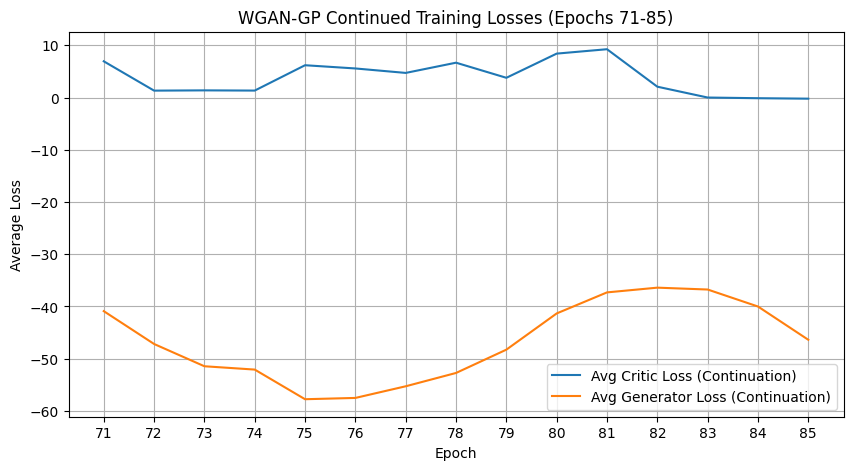

Updated 'critic' and 'generator' variables with weights from continued training.


In [19]:
# Cell 12.5: Continue WGAN-GP Training from Epoch 70 to 85 (loading weights - Build Fix Attempt 2)

import tensorflow as tf
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import logging # Use logging setup from Cell 1
# import fnmatch # Ensure fnmatch is imported if used later

print("\n--- Continuing WGAN-GP Training (Loading Weights) ---")

# --- Configuration ---
load_epoch = 70
start_epoch = load_epoch + 1
end_epoch = 85
continue_epochs = end_epoch - load_epoch

# Parameters (should match Cell 11/12 setup)
# Ensure these are correctly defined from previous cells:
# latent_dim, train_data_path, gan_batch_size, gp_weight, n_critic
# mel_spectrogram_shape (needed to recreate models)
# Learning rates from Cell 11 (use the ones you found most stable)
cont_critic_lr = 1e-5  # Example: Use the potentially lowered LR
cont_gen_lr = 1e-5     # Example: Use the potentially lowered LR

# --- Corrected File Paths for .weights.h5 ---
generator_weights_load_path = f'generator_wgan_sa_epoch_{load_epoch}.weights.h5'
critic_weights_load_path = f'critic_wgan_sa_epoch_{load_epoch}.weights.h5'

# --- Ensure Model Creation Functions and SelfAttention Class are Defined ---
# Make sure Cell 7 (SelfAttention), Cell 8 (create_generator), Cell 9 (create_critic)
# definitions were executed earlier in the notebook.
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found. Ensure Cell 7 was executed.")
if 'create_generator' not in locals(): raise NameError("create_generator function definition not found. Ensure Cell 8 was executed.")
if 'create_critic' not in locals(): raise NameError("create_critic function definition not found. Ensure Cell 9 was executed.")
if 'mel_spectrogram_shape' not in locals(): raise NameError("mel_spectrogram_shape variable not found. Ensure Cell 11 was executed.")
if 'N_MELS' not in locals() or 'TARGET_FRAMES' not in locals(): raise NameError("N_MELS or TARGET_FRAMES not defined. Ensure Cell 11 was executed.")
if 'latent_dim' not in locals(): raise NameError("latent_dim not defined. Ensure Cell 11 was executed.")


# --- Recreate Model Structures ---
print("Recreating model structures...")
generator_cont = create_generator(latent_dim, mel_spectrogram_shape)
critic_cont = create_critic(mel_spectrogram_shape)
print("Model structures recreated.")

# ---> BUILD MODELS VIA DUMMY FORWARD PASS <---
print("Building models via dummy forward pass...")
# Create dummy input tensors with batch size 1
dummy_critic_input = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
dummy_generator_input = tf.zeros((1, latent_dim), dtype=tf.float32)

try:
    # Call the models with the dummy inputs
    _ = critic_cont(dummy_critic_input, training=False) # training=False might be safer here
    _ = generator_cont(dummy_generator_input, training=False)
    print("Models built successfully via dummy pass.")
    # You can optionally print summary again to confirm layers are built
    # print("Critic Summary after build:")
    # critic_cont.summary()
except Exception as e:
    raise RuntimeError(f"Error building models via dummy pass: {e}")


# --- Load Weights ---
# Load generator weights (optional, if file exists)
# ... (loading logic remains the same as before) ...
if os.path.exists(generator_weights_load_path):
    print(f"Loading generator weights from: {generator_weights_load_path}")
    try:
        generator_cont.load_weights(generator_weights_load_path)
        print("Generator weights loaded successfully.")
    except Exception as e:
        print(f"Warning: Error loading generator weights: {e}. Generator starts with initial weights.")
else:
    print(f"Generator weights file not found: {generator_weights_load_path}. Generator starts with initial weights.")

# Load critic weights (Mandatory)
if not os.path.exists(critic_weights_load_path):
    raise FileNotFoundError(f"Critic weights file not found: {critic_weights_load_path}")

print(f"Loading critic weights from: {critic_weights_load_path}")
try:
    critic_cont.load_weights(critic_weights_load_path) # Now this *really* should work
    print("Critic weights loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading critic weights after build: {e}")


# --- Define Optimizers (Redefine for clarity/safety) ---
# ... (optimizer definitions remain the same) ...
critic_optimizer_cont = tf.keras.optimizers.Adam(learning_rate=cont_critic_lr, beta_1=0.5, beta_2=0.9)
generator_optimizer_cont = tf.keras.optimizers.Adam(learning_rate=cont_gen_lr, beta_1=0.5, beta_2=0.9)
print("Optimizers redefined.")

# --- Redefine Training Functions (to use loaded models/optimizers) ---
# ... (training function definitions remain the same) ...
def critic_loss_cont(real_output, fake_output):
    real_output = tf.cast(real_output, tf.float32); fake_output = tf.cast(fake_output, tf.float32)
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
def generator_loss_cont(fake_output):
    fake_output = tf.cast(fake_output, tf.float32)
    return -tf.reduce_mean(fake_output)
def gradient_penalty_cont(batch_size, real_images, fake_images):
    if real_images.dtype != fake_images.dtype: real_images = tf.cast(real_images, fake_images.dtype)
    alpha_shape = [tf.shape(real_images)[0]] + [1] * (len(real_images.shape) - 1)
    alpha = tf.random.uniform(shape=alpha_shape, minval=0., maxval=1., dtype=real_images.dtype)
    interpolated = real_images + alpha * (fake_images - real_images)
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated); pred = critic_cont(interpolated, training=True); pred = tf.cast(pred, tf.float32)
    grads = gp_tape.gradient(pred, [interpolated])
    if grads is None or grads[0] is None: logging.warning("Gradients are None in gradient_penalty_cont."); return tf.constant(0.0, dtype=tf.float32)
    grads = grads[0]; grads = tf.cast(grads, tf.float32)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.rank(grads)))); gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp * gp_weight
@tf.function
def train_step_cont(real_images):
    current_batch_size = tf.shape(real_images)[0]; noise = tf.random.normal([current_batch_size, latent_dim]); total_crit_loss = tf.constant(0.0, dtype=tf.float32)
    for _ in tf.range(n_critic):
        with tf.GradientTape() as crit_tape:
            fake_images = generator_cont(noise, training=True); real_output = critic_cont(real_images, training=True); fake_output = critic_cont(fake_images, training=True)
            crit_loss = critic_loss_cont(real_output, fake_output); gp = gradient_penalty_cont(current_batch_size, real_images, fake_images); total_crit_loss = crit_loss + gp
        crit_gradients = crit_tape.gradient(total_crit_loss, critic_cont.trainable_variables); valid_grads_and_vars = [(g, v) for g, v in zip(crit_gradients, critic_cont.trainable_variables) if g is not None]
        if len(valid_grads_and_vars) < len(critic_cont.trainable_variables): tf.print("Warning: Some critic gradients are None in cont step.")
        if len(valid_grads_and_vars) > 0: critic_optimizer_cont.apply_gradients(valid_grads_and_vars)
    with tf.GradientTape() as gen_tape:
        fake_images_gen = generator_cont(noise, training=True); fake_output_gen = critic_cont(fake_images_gen, training=True); gen_loss = generator_loss_cont(fake_output_gen)
    gen_gradients = gen_tape.gradient(gen_loss, generator_cont.trainable_variables); valid_grads_and_vars_gen = [(g, v) for g, v in zip(gen_gradients, generator_cont.trainable_variables) if g is not None]
    if len(valid_grads_and_vars_gen) < len(generator_cont.trainable_variables): tf.print("Warning: Some generator gradients are None in cont step.")
    if len(valid_grads_and_vars_gen) > 0: generator_optimizer_cont.apply_gradients(valid_grads_and_vars_gen)
    return total_crit_loss, gen_loss


# --- Data Generator ---
# ... (generator initialization and step calculation remain the same) ...
print("Initializing data generator for continued training...")
train_gen_gan_cont = data_generator_gan(train_data_path, batch_size=gan_batch_size)
if train_gen_gan_cont is None: raise RuntimeError("Failed to initialize GAN data generator.")
# Use function from Cell 13 or define count_total_files here if needed
# This counts both real and fake, data_generator_gan only uses fake
# We need the count of fake files only for the GAN generator steps
fake_files_count_cont = 0
try:
    fake_dir_cont = os.path.join(train_data_path, 'fake')
    if os.path.exists(fake_dir_cont):
        fake_files_count_cont = len([f for f in os.listdir(fake_dir_cont) if f.endswith('.wav')])
except Exception as e:
     print(f"Error counting fake files for continued training: {e}")

if gan_batch_size <= 0: raise ValueError("GAN Batch size must be positive.")
if fake_files_count_cont == 0: raise ValueError("No fake training files found for GAN.")
gan_steps_per_epoch_cont = int(np.ceil(fake_files_count_cont / float(gan_batch_size))) # Corrected count source
print(f"Using {gan_steps_per_epoch_cont} GAN steps per epoch for continued training.") # Corrected count source


# --- Continue Training Loop ---
# ... (training loop remains the same) ...
print(f"\nContinuing WGAN-GP training from epoch {start_epoch} to {end_epoch}...")
cont_c_loss_history = []; cont_g_loss_history = []
if train_gen_gan_cont is None or gan_steps_per_epoch_cont == 0:
    print("Skipping continued WGAN-GP training: Generator not initialized or no steps per epoch.")
else:
    for epoch in range(start_epoch, end_epoch + 1): # Loop from 71 to 85
        print(f"\nEpoch {epoch}/{end_epoch}")
        epoch_pbar_cont = tqdm(range(gan_steps_per_epoch_cont), desc=f"Epoch {epoch}")
        epoch_c_loss = 0.0; epoch_g_loss = 0.0; batches_processed = 0
        for batch_idx in epoch_pbar_cont:
            try:
                real_spoof_samples_np = next(train_gen_gan_cont); real_spoof_samples = tf.convert_to_tensor(real_spoof_samples_np, dtype=tf.float32)
                if tf.shape(real_spoof_samples)[0] == 0: print(f"Warning: Skipped empty batch at step {batch_idx} (cont)"); continue
                c_loss, g_loss = train_step_cont(real_spoof_samples)
                epoch_c_loss += c_loss.numpy(); epoch_g_loss += g_loss.numpy(); batches_processed += 1
                epoch_pbar_cont.set_postfix({"C Loss": f"{c_loss.numpy():.4f}", "G Loss": f"{g_loss.numpy():.4f}"})
            except StopIteration: print(f"\nGAN Generator exhausted prematurely at batch {batch_idx} (cont). Re-initializing."); train_gen_gan_cont = data_generator_gan(train_data_path, batch_size=gan_batch_size); break
            except Exception as e: logging.error(f"Error during continued WGAN training epoch {epoch}, batch {batch_idx}: {e}", exc_info=True); print(f"\nError during continued WGAN training epoch {epoch}, batch {batch_idx}: {e}"); continue
        if batches_processed > 0: avg_c_loss = epoch_c_loss / batches_processed; avg_g_loss = epoch_g_loss / batches_processed; cont_c_loss_history.append(avg_c_loss); cont_g_loss_history.append(avg_g_loss); print(f"Epoch {epoch} finished. Avg C Loss: {avg_c_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        else: print(f"Epoch {epoch} finished. No batches processed."); cont_c_loss_history.append(np.nan); cont_g_loss_history.append(np.nan)
        if (epoch % 5 == 0) or (epoch == end_epoch):
             try: generator_cont.save_weights(f'generator_wgan_sa_epoch_{epoch}.weights.h5'); critic_cont.save_weights(f'critic_wgan_sa_epoch_{epoch}.weights.h5'); print(f"Saved generator and critic weights for epoch {epoch}")
             except Exception as e: print(f"Error saving weights at epoch {epoch} (cont): {e}")
    print(f"\nContinued WGAN-GP training finished at epoch {end_epoch}.")
    plt.figure(figsize=(10, 5)); epoch_range = range(start_epoch, start_epoch + len(cont_c_loss_history)); plt.plot(epoch_range, cont_c_loss_history, label='Avg Critic Loss (Continuation)'); plt.plot(epoch_range, cont_g_loss_history, label='Avg Generator Loss (Continuation)'); plt.title(f'WGAN-GP Continued Training Losses (Epochs {start_epoch}-{end_epoch})'); plt.xlabel('Epoch'); plt.ylabel('Average Loss'); plt.xticks(list(epoch_range)); plt.legend(); plt.grid(True); plt.savefig(os.path.join(FIGURES_DIR, f'gan_loss_cont_{start_epoch}_to_{end_epoch}.png')); plt.show()
    critic = critic_cont; generator = generator_cont
    print("Updated 'critic' and 'generator' variables with weights from continued training.")

In [ ]:
# Cell 13: Train Standalone Classifier (using the *already trained* Critic from Cell 12.5)

import tensorflow as tf
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt # Ensure plt is imported
import logging
import fnmatch # Ensure fnmatch is imported if used later

# --- ADD PlotTrainingHistory CLASS DEFINITION AT THE BEGINNING ---
# (Make sure the class definition is present)
class PlotTrainingHistory(Callback):
    def __init__(self, model_name='model'):
        super().__init__()
        self.model_name = model_name
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.auc = [] # Added to track AUC
        self.val_auc = [] # Added to track validation AUC

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.auc.append(logs.get('auc')) # Get AUC
        self.val_auc.append(logs.get('val_auc')) # Get val_AUC

        plt.figure(figsize=(18, 5))
        # Accuracy Plot
        plt.subplot(1, 3, 1)
        if any(v is not None for v in self.acc): plt.plot(self.acc, label='Training Accuracy')
        if any(v is not None for v in self.val_acc): plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        if any(v is not None for v in self.acc) or any(v is not None for v in self.val_acc): plt.legend()
        # Loss Plot
        plt.subplot(1, 3, 2)
        if any(v is not None for v in self.loss): plt.plot(self.loss, label='Training Loss')
        if any(v is not None for v in self.val_loss): plt.plot(self.val_loss, label='Validation Loss')
        plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
        if any(v is not None for v in self.loss) or any(v is not None for v in self.val_loss): plt.legend()
        # AUC Plot
        plt.subplot(1, 3, 3)
        if any(v is not None for v in self.auc): plt.plot(self.auc, label='Training AUC')
        if any(v is not None for v in self.val_auc): plt.plot(self.val_auc, label='Validation AUC')
        plt.title('Model AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC')
        if any(v is not None for v in self.auc) or any(v is not None for v in self.val_auc): plt.legend()

        plt.tight_layout()
        filepath = os.path.join(FIGURES_DIR, f'{self.model_name}_epoch_{epoch+1}.png')
        try:
             plt.savefig(filepath)
             plt.close()
             print(f'\nTraining history plot saved to {filepath}')
        except Exception as e:
             print(f"\nError saving plot to {filepath}: {e}")
             plt.close()
# --- END OF CLASS DEFINITION ---


print("\nSetting up Standalone Classifier training...")

# --- Ensure Necessary Variables are Defined ---
# These should be defined in Cell 11 and accessible
if 'classifier_batch_size' not in locals(): raise NameError("classifier_batch_size not defined.")
if 'classifier_epochs' not in locals(): classifier_epochs = 50 # Default if needed
if 'train_data_path' not in locals(): raise NameError("train_data_path not defined.")
if 'dev_data_path' not in locals(): raise NameError("dev_data_path not defined.")
if 'count_total_files' not in locals(): raise NameError("count_total_files function not defined.") # Define in Cell 13 or earlier
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found.")
if 'FIGURES_DIR' not in locals(): FIGURES_DIR = 'training_figures_wgan_sa' # Default if needed

# --- Ensure the 'critic' variable from Cell 12.5 exists and is valid ---
print("Checking for pre-trained 'critic' model variable...")
if 'critic' not in locals() or not isinstance(critic, tf.keras.Model):
     # If 'critic = critic_cont' wasn't run or failed in 12.5, try loading the last saved weights as fallback
     print("Warning: 'critic' variable not found or invalid. Attempting to load last saved weights...")
     last_critic_weights_path = f'critic_wgan_sa_epoch_{end_epoch}.weights.h5' # Assuming end_epoch from 12.5 is available
     if os.path.exists(last_critic_weights_path):
          print(f"Found weights file: {last_critic_weights_path}. Recreating structure...")
          if 'create_critic' not in locals(): raise NameError("create_critic function needed.")
          if 'mel_spectrogram_shape' not in locals(): raise NameError("mel_spectrogram_shape needed.")
          critic = create_critic(mel_spectrogram_shape) # Recreate structure
          try:
               print("Building fallback critic via dummy pass...")
               dummy_critic_input = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
               _ = critic(dummy_critic_input, training=False)
               print("Loading weights...")
               critic.load_weights(last_critic_weights_path)
               print("Fallback weight loading successful.")
          except Exception as e:
               raise RuntimeError(f"Fallback failed: Error building/loading weights for critic: {e}")
     else:
          raise RuntimeError("The 'critic' model variable from WGAN training is not available, and fallback weights file not found.")

# Check if the critic model is built (it should be after Cell 12.5 or fallback)
if not critic.built:
     print("Warning: Critic model is not built. Attempting build via dummy pass...")
     try:
          # Ensure N_MELS, TARGET_FRAMES are defined
          if 'N_MELS' not in locals() or 'TARGET_FRAMES' not in locals(): raise NameError("N_MELS/TARGET_FRAMES needed for build.")
          dummy_critic_input = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
          _ = critic(dummy_critic_input, training=False)
          print("Critic built successfully via dummy pass.")
          if not critic.built: raise RuntimeError("Fallback build failed.")
     except Exception as e:
          raise RuntimeError(f"Error building critic model in Cell 13 fallback: {e}")
else:
    print("Using pre-trained and built 'critic' model variable.")


# --- Create Data Generators for Classifier ---
print("Initializing classifier data generators...")
train_gen_clf = data_generator_classifier(train_data_path, batch_size=classifier_batch_size)
dev_gen_clf = data_generator_classifier(dev_data_path, batch_size=classifier_batch_size, shuffle=False) # No shuffle for dev
if train_gen_clf is None or dev_gen_clf is None:
     raise RuntimeError("Failed to initialize classifier data generators.")


# --- Calculate steps for Classifier Training ---
print("Calculating classifier steps...")
train_samples_count = count_total_files(train_data_path)
dev_samples_count = count_total_files(dev_data_path)
if classifier_batch_size <= 0: raise ValueError("Classifier batch size must be positive.")
clf_steps_per_epoch = int(np.ceil(train_samples_count / float(classifier_batch_size))) if train_samples_count > 0 else 0
clf_validation_steps = int(np.ceil(dev_samples_count / float(classifier_batch_size))) if dev_samples_count > 0 else 0
print(f"Classifier Train Steps/Epoch: {clf_steps_per_epoch}, Validation Steps: {clf_validation_steps}")


# --- Build the Spoof Detector Model using the *EXISTING* Critic ---
print("Building classifier model using layers from the existing trained critic...")

# Ensure critic is trainable for fine-tuning
critic.trainable = True

# Create the new classifier model
spoof_detector = tf.keras.Sequential(name='spoof_detector')

# Add an Input layer matching the critic's expected input
critic_input_tensor_shape = critic.input_shape[1:] # Shape without batch dim
spoof_detector.add(tf.keras.layers.Input(shape=critic_input_tensor_shape, name='classifier_input'))
print(f"Using input shape for classifier model: {critic_input_tensor_shape}")

# Copy layers from the PRE-TRAINED critic (excluding its final output layer)
layers_copied_count = 0
for layer in critic.layers[:-1]:
    # Cloning is generally safer IF the layers are standard Keras layers or handle cloning well
    # For custom layers or complex nesting, adding directly might be okay if built correctly
    spoof_detector.add(layer)
    # Alternative (might be needed if layers don't transfer state properly):
    # new_layer = layer.__class__.from_config(layer.get_config())
    # spoof_detector.add(new_layer)
    layers_copied_count += 1
print(f"Copied {layers_copied_count} layers from the pre-trained critic.")

# Add the NEW final classification layer
spoof_detector.add(tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_output'))

# The model should be built now as layers were added sequentially with input shape defined
print("\n--- Spoof Detector (Classifier) Summary ---")
spoof_detector.summary() # Should display correctly now


# --- Callbacks for Classifier Training ---
print("Setting up callbacks...")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint_dir_clf = './training_checkpoints_spoof_detector_wgan_sa'
os.makedirs(checkpoint_dir_clf, exist_ok=True)
checkpoint_prefix_clf = os.path.join(checkpoint_dir_clf, "ckpt_clf_{epoch:02d}.weights.h5")
checkpoint_callback_clf = ModelCheckpoint(filepath=checkpoint_prefix_clf, save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
plot_training_callback = PlotTrainingHistory(model_name='spoof_detector_wgan_sa')


# --- Compile and Train the Classifier ---
print("Compiling classifier model...")
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # Use a smaller LR for fine-tuning
spoof_detector.compile(optimizer=classifier_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print("\nStarting Standalone Classifier training...")

if clf_steps_per_epoch > 0 and clf_validation_steps > 0:
    history = spoof_detector.fit(
        train_gen_clf,
        steps_per_epoch=clf_steps_per_epoch,
        epochs=classifier_epochs, # Use classifier_epochs defined in Cell 11
        validation_data=dev_gen_clf,
        validation_steps=clf_validation_steps,
        callbacks=[reduce_lr, early_stopping, checkpoint_callback_clf, plot_training_callback],
        # Generator yields weights as 3rd element, model.fit should use them
    )

    # Save the final trained classifier model (whole model)
    print("Saving final classifier model...")
    try:
        # Provide custom_objects for saving models with custom layers
        custom_objects_to_save = {'SelfAttention': SelfAttention}
        spoof_detector.save('spoof_detector_final_wgan_sa.keras', custom_objects=custom_objects_to_save)
        print("\nClassifier training complete. Final model saved as spoof_detector_final_wgan_sa.keras")
    except Exception as e:
         print(f"\nError saving final classifier model as .keras: {e}. Saving weights only as fallback.")
         spoof_detector.save_weights('spoof_detector_final_wgan_sa.weights.h5')

    # --- Load best weights based on checkpoint and save best model ---
    print("Loading best weights and saving best model...")
    try:
        best_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir_clf)
        if best_checkpoint_path:
            print(f"Loading best classifier weights from: {best_checkpoint_path}")
            # Load weights into the existing model structure
            spoof_detector.load_weights(best_checkpoint_path)
            # Save the model with best weights loaded
            spoof_detector.save('spoof_detector_best_val_auc_wgan_sa.keras', custom_objects=custom_objects_to_save)
            print("Saved classifier with best validation AUC weights as spoof_detector_best_val_auc_wgan_sa.keras")
        else:
            print("Could not find best checkpoint weights to load. Final model/weights already saved.")
    except Exception as e:
        print(f"Error loading/saving best weights: {e}")

else:
    print("Skipping classifier training because steps_per_epoch or validation_steps is zero.")


Setting up Standalone Classifier training...
Checking for pre-trained 'critic' model variable...
Using pre-trained and built 'critic' model variable.
Initializing classifier data generators...
Calculating classifier steps...
Classifier Train Steps/Epoch: 3173, Validation Steps: 3106
Building classifier model using layers from the existing trained critic...
Using input shape for classifier model: (80, 126, 1)
Copied 10 layers from the pre-trained critic.

--- Spoof Detector (Classifier) Summary ---


Model: "spoof_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 40, 63, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 40, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 20, 32, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (None, 20, 32, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 20, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_11               │ (None, 20, 32, 128)    │        37,153 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 10, 16, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_23          │ (None, 10, 16, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 10, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 1)              │        40,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,330 (2.81 MB)

 Trainable params: 735,330 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

Setting up callbacks...
Compiling classifier model...

Starting Standalone Classifier training...
Using class weights: {1: 4.9186046511627906, 0: 0.5565789473684211} for path datasetNEW/train
Epoch 1/60
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6976 - auc: 0.8153 - loss: 0.5100Using class weights: {1: 4.875196232339089, 0: 0.557140294223179} for path datasetNEW/dev


2025-04-06 00:28:43.362813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 248 bytes spill stores, 248 bytes spill loads

2025-04-06 00:28:43.569908: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 108 bytes spill stores, 108 bytes spill loads

2025-04-06 00:28:43.648210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 64 bytes spill stores, 64 bytes spill loads

2025-04-06 00:28:43.694467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 220 bytes spill stores, 184 bytes spill loads

2025-04-06 00:28:43.793412: I external


Epoch 1: val_auc improved from -inf to 0.92909, saving model to ./training_checkpoints_spoof_detector_wgan_sa/ckpt_clf_01.weights.h5

Training history plot saved to training_figures_wgan_sa/spoof_detector_wgan_sa_epoch_1.png
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 488s 153ms/step - accuracy: 0.6976 - auc: 0.8154 - loss: 0.5100 - val_accuracy: 0.8431 - val_auc: 0.9291 - val_loss: 0.3085 - learning_rate: 1.0000e-05
Epoch 2/60
3172/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8644 - auc: 0.9543 - loss: 0.2559
Epoch 2: val_auc improved from 0.92909 to 0.94675, saving model to ./training_checkpoints_spoof_detector_wgan_sa/ckpt_clf_02.weights.h5

Training history plot saved to training_figures_wgan_sa/spoof_detector_wgan_sa_epoch_2.png
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 496s 156ms/step - accuracy: 0.8644 - auc: 0.9543 - loss: 0.2559 - val_accuracy: 0.8723 - val_auc: 0.9468 - val_loss: 0.2784 - learning_rate: 1.0000e-05
Epoch 3/60
3172/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8982 - a

In [ ]:
# Cell 14: Evaluation (Revised Loading - Structure + Weights.h5)

import tensorflow as tf
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt # Ensure plt is imported if needed later
import logging
import fnmatch # Ensure fnmatch is imported

print("\nEvaluating the final Spoof Detector...")

# --- Parameters needed to recreate the model ---
# Ensure these variables are accessible from previous cells (e.g., Cell 11)
if 'N_MELS' not in locals() or 'TARGET_FRAMES' not in locals(): raise NameError("N_MELS or TARGET_FRAMES not defined. Ensure Cell 11 was executed.")
if 'mel_spectrogram_shape' not in locals(): raise NameError("mel_spectrogram_shape not defined. Ensure Cell 11 was executed.")
if 'create_critic' not in locals(): raise NameError("create_critic function definition not found. Ensure Cell 9 was executed.")
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found. Ensure Cell 7 was executed.")
if 'classifier_batch_size' not in locals(): raise NameError("classifier_batch_size not defined.")
if 'eval_data_path' not in locals(): eval_data_path = 'datasetNEW/eval' # Default if needed
if 'count_total_files' not in locals(): raise NameError("count_total_files function not defined.") # Needs definition from Cell 13 or earlier
if 'FIGURES_DIR' not in locals(): FIGURES_DIR = 'training_figures_wgan_sa' # Default if needed

# --- Define Model Paths ---
checkpoint_dir_clf = './training_checkpoints_spoof_detector_wgan_sa' # Checkpoint dir from Cell 13
final_weights_path_clf = 'spoof_detector_final_wgan_sa.weights.h5' # Final weights save from Cell 13

weights_path_to_load = None
best_checkpoint = tf.train.latest_checkpoint(checkpoint_dir_clf)

if best_checkpoint:
    print(f"Found best weights checkpoint: {best_checkpoint}")
    weights_path_to_load = best_checkpoint
elif os.path.exists(final_weights_path_clf):
    print(f"Best weights checkpoint not found. Using final weights file: {final_weights_path_clf}")
    weights_path_to_load = final_weights_path_clf
else:
    print(f"ERROR: No weights file found at '{checkpoint_dir_clf}' (best) or '{final_weights_path_clf}' (final).")
    weights_path_to_load = None

# --- Recreate, Build, and Load Model ---
spoof_detector_eval = None
evaluation_model_loaded = False

if weights_path_to_load:
    print("Recreating spoof_detector architecture for evaluation...")
    try:
        # 1. Recreate the exact structure as defined in Cell 13
        eval_input_shape = (N_MELS, TARGET_FRAMES, 1)
        temp_critic_structure = create_critic(mel_spectrogram_shape) # Create base structure

        spoof_detector_eval = tf.keras.Sequential(name='spoof_detector_eval')
        spoof_detector_eval.add(tf.keras.layers.Input(shape=eval_input_shape, name='classifier_input'))
        layers_copied_count = 0
        for layer in temp_critic_structure.layers[:-1]: # Copy all but the last Dense(1) layer
            new_layer = layer.__class__.from_config(layer.get_config())
            spoof_detector_eval.add(new_layer)
            layers_copied_count +=1
        del temp_critic_structure # Clean up
        spoof_detector_eval.add(tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_output'))
        print(f"Recreated {layers_copied_count + 1} layers for spoof_detector_eval.")

        # 2. Build the recreated model using a dummy pass
        print("Building recreated model via dummy pass...")
        dummy_eval_input = tf.zeros((1,) + eval_input_shape, dtype=tf.float32)
        _ = spoof_detector_eval(dummy_eval_input, training=False)
        print("Recreated model built.")
        # Optional: print summary to verify build status
        # print("Summary of recreated model:")
        # spoof_detector_eval.summary()

        # 3. Load the weights
        print(f"Loading weights from: {weights_path_to_load}")
        spoof_detector_eval.load_weights(weights_path_to_load)
        print("Weights loaded successfully into recreated structure.")
        evaluation_model_loaded = True

    except Exception as e:
        print(f"\n--- ERROR DURING MODEL RECREATION OR WEIGHT LOADING ---")
        print(f"Error details: {e}")
        print("---------------------------------------------")
        spoof_detector_eval = None # Ensure model is None if process failed

# --- Compile the Model (Essential after loading weights) ---
if evaluation_model_loaded:
    try:
        print("Compiling evaluation model...")
        eval_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # LR doesn't matter for eval
        spoof_detector_eval.compile(
            optimizer=eval_optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        print("Model compiled successfully.")
    except Exception as e:
        print(f"\n--- ERROR compiling model: {e} ---")
        evaluation_model_loaded = False
else:
     print("Skipping compilation because model weights were not loaded/structure failed.")


# --- Proceed with Evaluation if Model is Ready ---
if evaluation_model_loaded:
    print("\nProceeding with evaluation...")
    # Create Evaluation Generator
    print("Initializing evaluation data generator...")
    eval_gen_clf = data_generator_classifier(eval_data_path, batch_size=classifier_batch_size, shuffle=False)
    if eval_gen_clf is None:
         print("ERROR: Evaluation generator failed to initialize.")
         # Handle error appropriately, maybe skip evaluation
    else:
        # Calculate Evaluation Steps
        eval_samples_count = count_total_files(eval_data_path)
        if classifier_batch_size <= 0: raise ValueError("Classifier batch size must be positive.")
        eval_steps = int(np.ceil(eval_samples_count / float(classifier_batch_size))) if eval_samples_count > 0 else 0
        print(f"Using {eval_steps} steps for evaluation.")

        # Evaluate
        if eval_steps > 0:
            try:
                results = spoof_detector_eval.evaluate(
                    eval_gen_clf,
                    steps=eval_steps,
                    verbose=1
                )
                print("\n--- Evaluation Results ---")
                if len(results) >= 3:
                     print(f"Loss: {results[0]:.4f}")
                     print(f"Accuracy: {results[1]:.4f}")
                     print(f"AUC: {results[2]:.4f}")
                else:
                    print(f"Results (raw): {results}")
                print("--------------------------")
            except Exception as e:
                print(f"\n--- ERROR DURING EVALUATION RUN ---")
                print(f"Error details: {e}")
                print("-----------------------------")
        else:
            print("Skipping evaluation because eval_steps is zero.")
else:
    print("\nSkipping evaluation because the spoof detector model could not be loaded/compiled correctly.")


Evaluating the final Spoof Detector...
Best weights checkpoint not found. Using final weights file: spoof_detector_final_wgan_sa.weights.h5
Recreating spoof_detector architecture for evaluation...
Recreated 11 layers for spoof_detector_eval.
Building recreated model via dummy pass...
Recreated model built.
Loading weights from: spoof_detector_final_wgan_sa.weights.h5
Weights loaded successfully into recreated structure.
Compiling evaluation model...
Model compiled successfully.

Proceeding with evaluation...
Initializing evaluation data generator...
Using 8905 steps for evaluation.
Using class weights: {1: 4.842760027192386, 0: 0.557567076797846} for path datasetNEW/eval
8904/8905 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8539 - auc: 0.8342 - loss: 0.6362

2025-04-06 04:36:10.544306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 248 bytes spill stores, 248 bytes spill loads

2025-04-06 04:36:10.962143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 108 bytes spill stores, 108 bytes spill loads

2025-04-06 04:36:10.981578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 64 bytes spill stores, 64 bytes spill loads

2025-04-06 04:36:11.153210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 220 bytes spill stores, 184 bytes spill loads

2025-04-06 04:36:11.265028: I external

8905/8905 ━━━━━━━━━━━━━━━━━━━━ 704s 79ms/step - accuracy: 0.8539 - auc: 0.8342 - loss: 0.6361

--- Evaluation Results ---
Loss: 0.4775
Accuracy: 0.8267
AUC: 0.9299
--------------------------



Generating Final Reports (F1, CM, EER, t-DCF)...
Generating predictions using 8905 steps...


Predicting:   0%|          | 0/8905 [00:00<?, ?it/s]

Using class weights: {1: 4.842760027192386, 0: 0.557567076797846} for path datasetNEW/eval

F1 Score (threshold 0.5): 0.5257


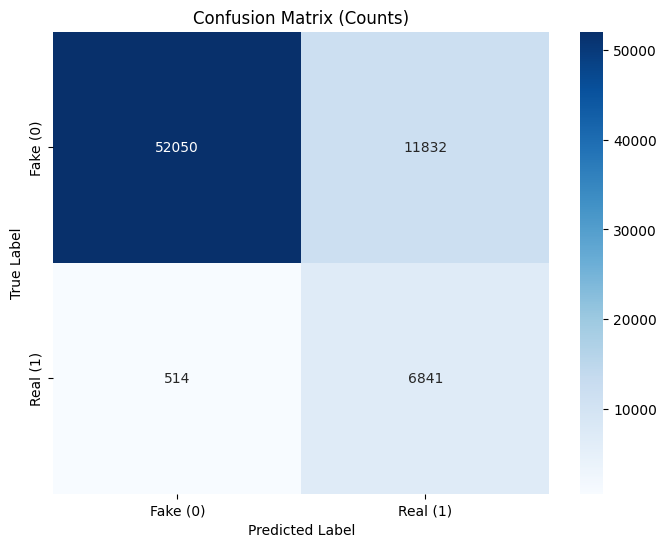

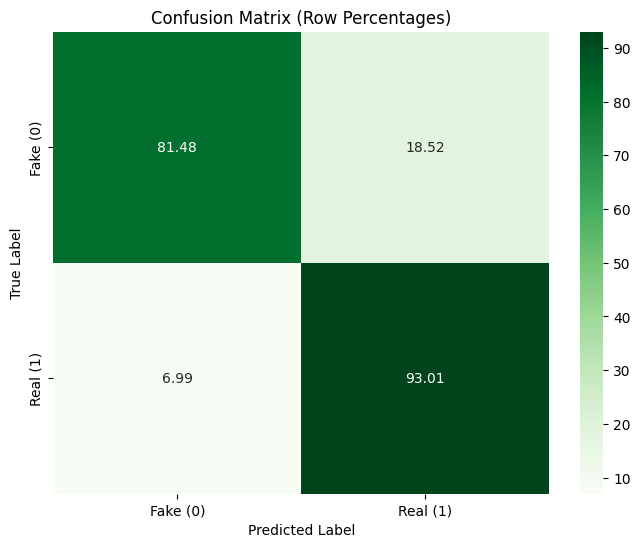

EER: 0.1416 at threshold 0.8393


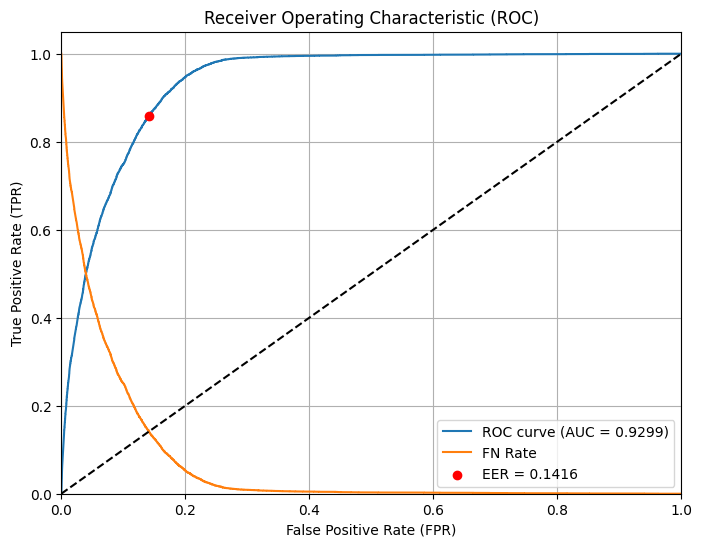

Minimum t-DCF: 0.9446 at threshold 0.9999


In [24]:
# Cell 15: Reporting (Confusion Matrix, EER, t-DCF)

print("\nGenerating Final Reports (F1, CM, EER, t-DCF)...")

# Ensure the evaluation model is loaded from Cell 14
if 'spoof_detector_eval' not in locals() or spoof_detector_eval is None:
    print("Spoof detector model not loaded. Cannot generate reports.")
else:
    # --- Parameters for t-DCF ---
    p_target = 0.05  # Prior probability of target (real=1) - Adjust based on ASVspoof challenge or use case
    c_miss = 1       # Cost of miss (classifying real as fake - FN)
    c_false_alarm = 1 # Cost of false alarm (classifying fake as real - FP)

    # --- Regenerate Predictions ---
    # Reset the eval generator
    eval_gen_report = data_generator_classifier(eval_data_path, batch_size=classifier_batch_size, shuffle=False)

    # Recalculate eval_steps if needed (should match Cell 14)
    eval_samples_count_report = count_total_files(eval_data_path)
    eval_steps_report = int(np.ceil(eval_samples_count_report / float(classifier_batch_size))) if eval_samples_count_report > 0 else 0

    y_pred_scores = []
    y_true_labels = []

    if eval_steps_report > 0:
        print(f"Generating predictions using {eval_steps_report} steps...")
        for _ in tqdm(range(eval_steps_report), desc="Predicting"):
            try:
                # Generator yields (batch_x, batch_y, batch_weights)
                batch_x, batch_y, _ = next(eval_gen_report)
                if batch_x.size == 0: continue # Skip empty batches if they occur

                # Use predict, not predict_on_batch for potentially better performance over many batches
                batch_pred = spoof_detector_eval.predict(batch_x, verbose=0)
                y_pred_scores.extend(batch_pred.flatten())
                y_true_labels.extend(batch_y)
            except StopIteration:
                print("Evaluation generator stopped.")
                break
            except Exception as e:
                print(f"Error during prediction generation: {e}")
                continue

        y_pred_scores = np.array(y_pred_scores).astype(np.float32)
        y_true_labels = np.array(y_true_labels).astype(np.int32)

        # Ensure lengths match (might be off if last batch was incomplete and generator didn't handle it perfectly)
        min_len = min(len(y_pred_scores), len(y_true_labels))
        if min_len == 0:
            print("No predictions or labels collected. Cannot generate reports.")
        else:
            y_pred_scores = y_pred_scores[:min_len]
            y_true_labels = y_true_labels[:min_len]

            # --- Calculations ---
            # Binary predictions for F1 and CM
            y_pred_binary = (y_pred_scores > 0.5).astype(int)

            # F1 Score
            f1 = f1_score(y_true_labels, y_pred_binary)
            print(f"\nF1 Score (threshold 0.5): {f1:.4f}")

            # Confusion Matrix
            cm = confusion_matrix(y_true_labels, y_pred_binary)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
            plt.title('Confusion Matrix (Counts)')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_counts_wgan_sa.png'))
            plt.show()

            # Confusion Matrix (Percentages)
            cm_sum = np.sum(cm, axis=1, keepdims=True)
            cm_perc = cm / cm_sum.astype(float) * 100
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_perc, annot=True, fmt='.2f', cmap='Greens', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
            plt.title('Confusion Matrix (Row Percentages)')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_perc_wgan_sa.png'))
            plt.show()


            # EER Calculation
            fpr, tpr, thresholds_roc = roc_curve(y_true_labels, y_pred_scores, pos_label=1)
            fnr = 1 - tpr
            eer_index = np.nanargmin(np.abs(fnr - fpr))
            eer_threshold = thresholds_roc[eer_index]
            eer = fpr[eer_index] # Or use (fpr[eer_index] + fnr[eer_index]) / 2
            print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")

            # Plot ROC Curve
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {results[2]:.4f})') # Use AUC from evaluate
            plt.plot(fpr, fnr, label='FN Rate')
            plt.plot([0, 1], [0, 1], 'k--') # Random guess line
            plt.scatter(fpr[eer_index], tpr[eer_index], color='red', zorder=5, label=f'EER = {eer:.4f}')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate (FPR)')
            plt.ylabel('True Positive Rate (TPR)')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve_wgan_sa.png'))
            plt.show()


            # t-DCF Calculation
            # Define function (can be moved to utils if used often)
            def calculate_t_dcf(y_true, y_scores, p_target, c_miss, c_fa, thresholds):
                """Calculates normalized t-DCF for a range of thresholds."""
                num_thresholds = len(thresholds)
                dcf_values = np.zeros(num_thresholds)

                num_real = np.sum(y_true == 1)
                num_fake = np.sum(y_true == 0)

                if num_real == 0 or num_fake == 0:
                     print("Warning: Cannot calculate t-DCF with zero samples in a class.")
                     return np.inf # Return infinity or handle as error

                for i, thr in enumerate(thresholds):
                    y_pred_binary = (y_scores >= thr).astype(int)
                    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary, labels=[0, 1]).ravel()

                    p_miss = fn / num_real if num_real > 0 else 0 # Miss Rate (FN / Total Real)
                    p_fa = fp / num_fake if num_fake > 0 else 0   # False Alarm Rate (FP / Total Fake)

                    cost = (c_miss * p_miss * p_target) + (c_fa * p_fa * (1 - p_target))

                    # Normalize the cost
                    dcf_norm = min(c_miss * p_target, c_fa * (1 - p_target))
                    dcf_values[i] = cost / dcf_norm if dcf_norm > 0 else cost # Avoid division by zero

                # Find the minimum t-DCF
                min_dcf_index = np.argmin(dcf_values)
                min_dcf = dcf_values[min_dcf_index]
                min_dcf_threshold = thresholds[min_dcf_index]

                return min_dcf, min_dcf_threshold

            # Calculate min t-DCF over a range of thresholds (more robust than just EER threshold)
            # Use ROC thresholds, but filter out +/- inf if present
            valid_thresholds = thresholds_roc[np.isfinite(thresholds_roc)]
            min_tdcf, min_tdcf_thresh = calculate_t_dcf(y_true_labels, y_pred_scores, p_target, c_miss, c_false_alarm, valid_thresholds)

            print(f"Minimum t-DCF: {min_tdcf:.4f} at threshold {min_tdcf_thresh:.4f}")

    else:
         print("Skipping report generation because eval_steps_report is zero.")